# Try to do some realistic simulation

In [7]:
import os
os.environ["OMP_NUM_THREADS"] = "4" # export OMP_NUM_THREADS=4

In [8]:
import batoid
import numpy as np
import matplotlib.pyplot as plt

In [94]:
telescope = batoid.Optic.fromYaml("ComCamSpiders_g.yaml")
factor = 0.2/1e-5/3600

# Make refractive interfaces partially reflective
for surface in telescope.itemDict.values():
        if isinstance(surface, batoid.RefractiveInterface):
            if surface.name.split('_')[0] in ['L1', 'L2', 'L3']:
                surface.forwardCoating = batoid.SimpleCoating(0.004, 0.996)
                surface.reverseCoating = batoid.SimpleCoating(0.004, 0.996)
            elif surface.name.split('_')[0] in ['Filter']:
                surface.forwardCoating = batoid.SimpleCoating(0.04, 0.96)
                surface.reverseCoating = batoid.SimpleCoating(0.04, 0.96)
        if isinstance(surface, batoid.Detector):
            surface.forwardCoating = batoid.SimpleCoating(0.15, 0.85)

In [95]:
# Initialize variable
#angles = [(-1, 0), (0, 1), (1.2, 0)]
angles = [(-0.5, 0),(-0.02, 0.35),(0.3, 0.15)]
#angles = [(0.3, 0.15)]
x, y, flux = [], [], []
debug = False

In [96]:
# Start calculus
for angle in angles:
    print(angle)
    rays = batoid.RayVector.asPolar(
        optic=telescope, wavelength=500e-9,
        theta_x=np.deg2rad(angle[0]), theta_y=np.deg2rad(angle[1]),
        nrad=300, naz=900
    )

    rForward, rReverse = telescope.traceSplit(rays, minFlux=1e-4, _verbose=False) # _verbose = log calculus

    for i, rr in enumerate(rForward):
        x.append([ix for ix in rr.x])
        y.append([iy for iy in rr.y])
        flux.append([iflux for iflux in rr.flux])

if debug:
    print("# input rays          = {}".format(len(rays)))
    print("# forward output rays = {}".format(sum(len(rr) for rr in rForward)))
    print("# reverse output rays = {}".format(sum(len(rr) for rr in rReverse)))
    print("input flux          = {}".format(np.sum(rays.flux)))
    forwardFlux = np.sum([np.sum(rr.flux) for rr in rForward])
    reverseFlux = np.sum([np.sum(rr.flux) for rr in rReverse])
    print("forward output flux = {}".format(forwardFlux))
    print("reverse output flux = {}".format(reverseFlux))
    print("destroyed flux      = {}".format(
        np.sum(rays.flux) - forwardFlux - reverseFlux
    ))

(-0.5, 0)
(-0.02, 0.35)
(0.3, 0.15)


In [97]:
# Regroup and stock data
x = np.concatenate([ix for ix in x])
y = np.concatenate([iy for iy in y])
flux = np.concatenate([iflux for iflux in flux])

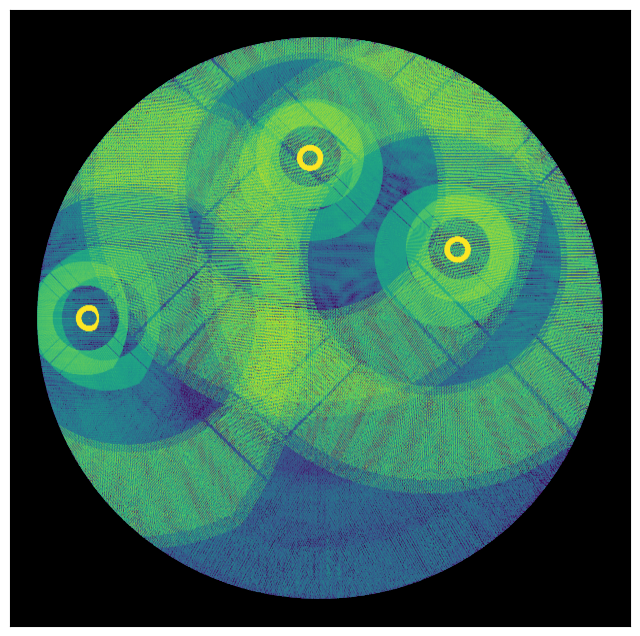

In [100]:
# Do a beautiful plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
ax.hexbin(
    x, y, flux,
    reduce_C_function=np.sum, vmax=4e-2, gridsize=1000, bins='log'
)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
#ax.set_position([0,0,1,1])
ax.set_facecolor('black')
plt.show()